<h1>ARIMA modeling & prediction </h1>

The general process for ARIMA models is the following:
<ol>
  <li>Visualize data.</li>
  <li>Identification.</li>
  <li>Model fitting.</li>
  <li>Diagnostic Checking.</li>
  <li>Prediction.</li>
</ol>

<h2>Loading libraries</h2>

In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings("ignore")

<h2>Data Exploration & Visualization</h2>

In [4]:
df = pd.read_csv('power_consumption.csv')

In [5]:
df.tail()

,time,load
38,3-1-2020,13274714
39,4-1-2020,10839757
40,5-1-2020,10033897
41,6-1-2020,8913169
42,7-1-2020,8139394


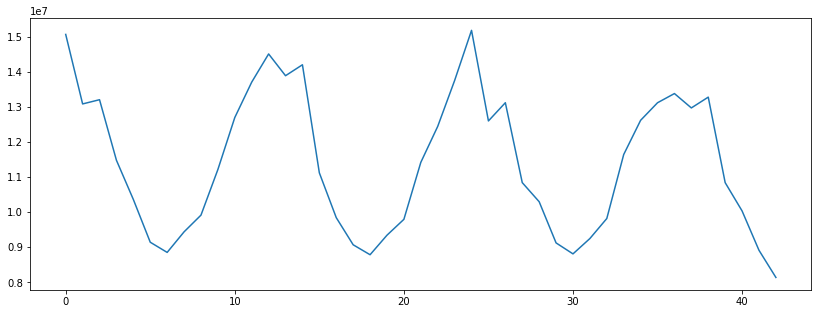

In [6]:
size = (14,5)
df['load'].plot(figsize = size)

In [7]:
train_df = df[:36].copy()
test_df = df[36:].copy()

In [8]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
load,36.0,1.146320e+07,2.003853e+06,8786241.0,9705321.0,11315082.0,13114949.0,15176458.0


<h2>1. Identification & Transform</h2>

In [9]:
#mean-corrected
mean = train_df['load'].mean()
train_df['load'] = train_df['load'] - mean

<h3>1.1. Seasonality Elimination </h3>

In [10]:
train_df_12 = train_df['load'].diff(periods = 12)
train_df_12.dropna(inplace = True)

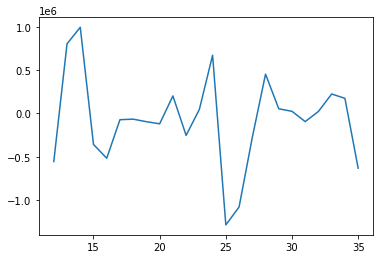

In [11]:
train_df_12.plot()

<h3> 1.2. ADF Test for Stationarity </h3>

Stationary testing after differencing

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
dftest = adfuller(train_df_12, autolag = 'AIC')

In [14]:
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.940566559417269
2. P-Value :  2.9058469399843995e-05
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 22
5. Critical Values :
	 1% :  -3.769732625845229
	 5% :  -3.005425537190083
	 10% :  -2.6425009917355373


<h3>1.3. ACF & PACF plot</h3>

In [15]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

In [16]:
time_series = train_df_12

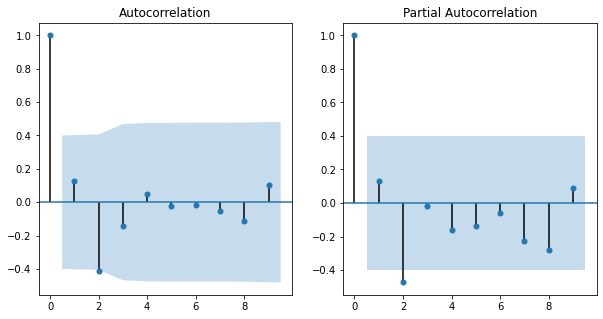

In [17]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
plot_acf(time_series.values.squeeze(), lags=9, ax=ax[0])
plot_pacf(time_series.values.squeeze(), lags=9, ax=ax[1])
plt.show()

<h2>2. Model fitting</h2>

In [18]:
from statsmodels.tsa.arima.model import ARIMA

In [19]:
train_data = train_df['load']

In [20]:
#define order of model
order = (2,0,2) #p,d,q
seasonal_order = (0, 1, 0, 12) #P,D,Q 

In [21]:
# define model
model = ARIMA(train_data, order=order, seasonal_order=seasonal_order)

In [22]:
#training model
sarima_model = model.fit()

In [23]:
#summary of the model
print(sarima_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                              load   No. Observations:                   36
Model:             ARIMA(2, 0, 2)x(0, 1, [], 12)   Log Likelihood                -346.340
Date:                           Thu, 03 Feb 2022   AIC                            702.681
Time:                                   19:01:25   BIC                            708.571
Sample:                                        0   HQIC                           704.243
                                            - 36                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6025      0.078     -7.717      0.000      -0.755      -0.449
ar.L2         -0.9893      0.058    -17.065

<h2>3. Diagnostic Checking</h2>

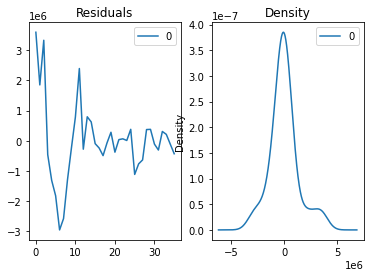

In [24]:
# Plot residual errors
residuals = pd.DataFrame(sarima_model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [25]:
#rescaling residuals
std = residuals[0].std()
rescaled_residuals = residuals/std

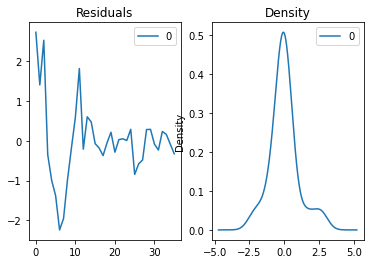

In [26]:
# Plot rescaled residual errors
fig, ax = plt.subplots(1,2)
rescaled_residuals.plot(title="Residuals", ax=ax[0])
rescaled_residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Plotting ACF for residuals

In [27]:
from statsmodels.tsa.stattools import acf

<BarContainer object of 20 artists>

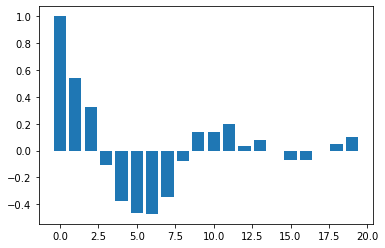

In [28]:
acf_vals = acf(rescaled_residuals)
num_lags = 20
plt.bar(range(num_lags), acf_vals[:num_lags])

<h2>4. Prediction</h2>

In [29]:
test_data = test_df['load']

In [30]:
#get the predictions and residuals
predictions = sarima_model.forecast(len(test_data)) + mean
predictions = pd.Series(predictions, index=test_data.index)

In [31]:
true_data = df['load']

Text(0, 0.5, 'Power Consumption')

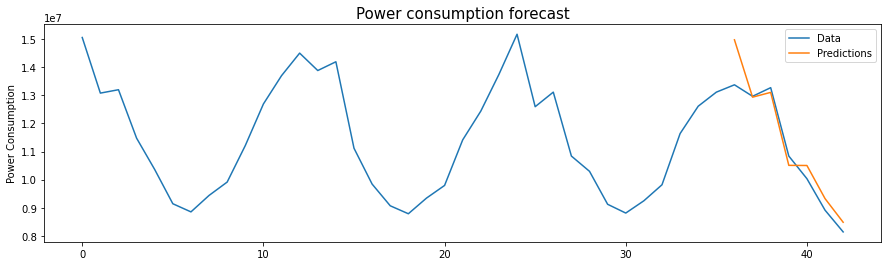

In [32]:
plt.figure(figsize=(15,4))

plt.plot(true_data)
plt.plot(predictions)

plt.legend(('Data', 'Predictions'), fontsize=10)

plt.title('Power consumption forecast', fontsize=15)
plt.ylabel('Power Consumption', fontsize=10)

In [33]:
from math import sqrt

Text(0, 0.5, 'Error')

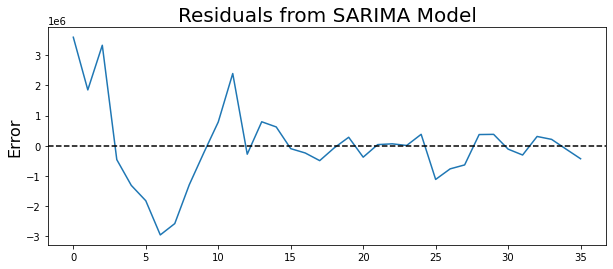

In [34]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Residuals from SARIMA Model', fontsize=20)
plt.ylabel('Error', fontsize=16)